# Chapter 11

In this project I used Princple Component Analysis to examine the degree of separability between modeled neuron electrical recordings and real electrical recordings from actual neurons.

If biologically realistic models were better at imitating real experimental cells, then data and models would not easily be discriminable. By plotting a 48 dimensional feature space onto a two dimensional projection space, I show that a diverse pool of data and models are readily discriminated via Random Forest Classification, a result, that leaves even some of the most optimized models lacking. The idea is that the models which are the most resistant to being correctly machine-classified as models (therefore being misclassified as data), serve as better imitations/mimics of experimental data. I also used random forest regression to investigate when experimental data inform a classifying statistical model which dimensions explain the most of the observed variance in the feature space. Variance-explained will facilitate the production of a list of improvements to make to our models in order to render models better imitations of real data.

In this project you can see use of:
* PCA, t-Distributed Stochastic Neighbor Embedding (t-SNE).
* Random Forest Classification (RFC) using 38 features, and also RFC applied to just 2 features (output from PCA).
* using the RFC "variance-explained" feature. 
* Plotting of a decision boundary.
* Not done yet, but pending Cross-Validation using looping over many different test/train splits.

### Broader Project Context and Background:

There is a great diversity of real biological neurons, all of which differ substantially in their electrical behavior. There are a few different classes of general purpose neuronal models, that can reproduce these different types of electrical behaviours, given appropriate parameterizations of the models.

An exisiting class of neuron model type, called The Izhikevich model was published with parameter sets believed to make the model outputs accurately align with a variety of real biological cell outputs. However since publication much very specific electro physiological recordings have accumulated, that in someways undermine model/experiment agreement. However it is now possible to constrain the Izhikevich model and find new parameterizations that more allow us to more accurately reproduce more recently published experimental data.

In contrast to other projects that seek to use features to seperate and classify two different categories of things that are hard to tell apart, such that humans can benefit from a fast classification of hard to discern differences in high dimensional spaces. In this project the goal is to use resistance to classification as an indicator of an optimization algorithms success, and to use machine seperation of data categories as an error signal, that directs us to precise locations of model failure. Another way of saying this, is, if a good/fair attempt at machine classification is hard, then then a different machine learning algorithm did a good job. If machine classification is very easy, the optimization algorithm did a poor job.

In the figure below you can some different electrical behavior corresponding to two different multi-spiking electrical experiments.
![electrical_behavior.png](electrical_behavior.png)

### Code authorship.
I used the approach described herein for different research work intended for a conference abstract published as follows:
J Birgiolas, R Jarvis, V Haynes, R Gerkin, SM Crook (2019) Automated assessment and comparison of cortical neuron models BMC Neuroscience 2019, 20(Suppl 1):P47 

The application of TSNE to data was developed in a research team context on different data pertaining to ion channels, or the APs exclusively derived from models (as opposed to a combination of models and data). In the context of this project, I have used novel experimental data (pulled from the Allen Brain Portal API) and novel models (8 optimized cell models included), so I have re-applied a small amount of code from pre-established work, but I have made substantial novel contributions, by looking at different features, applying different feature engineering, applying Random Forest Classification, applying variance explained, and interpreting results. For a comparison to other pre-established work that informed this work check [here](https://github.com/vrhaynes/LargeScaleModelAnalysis_2019/blob/master/model-data-clustering.ipynb)

### Model Optimization as a data pre-processing stage.
Before Machine Learning and analysis techniques could be applied, we needed to find optimized models. These optimized models can be understood as models that are intended to be superior mimics of real biologically derived data, as their governing equation parameters have been more rigorously constrained  by a wider range of experimental data.

In order illustrate that the optimized models are better imitations of real data, four adaptive Exponential models, and four Izhikevich models each were fitted to four different classes of experimental cells see implementation in ipython notebook [Notebook](https://github.com/russelljjarvis/neuronunit/blob/master/neuronunit/examples/seperate_out_data_new_models.ipynb). These eight fitted models were subsequently fed into a Druckman feature extraction algorithm, and added as data points in a dimension reduced plot of the feature space. Many pre-existing neural models, and some Allen Brain Data where also plotted as contextual data in the same feature space.

## Project Implementation and Technologies

* Python, pandas sklearn, dask were all used for Model Optimization pre-processing steps, and for plotting the models in a dimension reduced feature space.
* Models versus Data. Models which are resistant to being classified as models are more successful, and better representatives of data. See below.
* The optimized cells were derived from a custom built parallel genetic algorithm, utilizing pre-existing python tools: ***DEAP*** and ***Dask***. It would have been desirable to optimize the models with an algorithm from this course, such as  Lasso, ridge regression, and elastic search (L1+L2)/2 regularization combined. The way I do this is to run a genetic algorithm over the data, The genetic algorithm is performing its own type of guided sparse sampling of the data.

The Druckman feature analysis protocol originates from MATLAB code associated with the analysis of Blue Brain Project Modelled cells, this feature analysis pipeline was then ported to Python by Justas Birgiolas, at a later point I made the feature analysis pipeline applicable to optimized Adaptive Exponential and Izhiketch cells. Rick Gerkin and Vergil Haynes, assisted in data cleaning preperation and TSNE application.



In [1]:
import os
import dask.dataframe as dd    
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(font_scale=1.5)
import pandas as pd
os.getcwd()
from sklearn.preprocessing import StandardScaler
import copy


In [2]:
try:
    with open('dm_on_models.p','rb') as f:
        (RAW_dtc,ADEXP_dtc) = pickle.load(f)
except:
    pass
    os.system('wget dm_on_models.p')

gets here
(-75, -56)
Import of badexp.ADEXPBackend failed due to:
No module named 'neuronunit.models.backends.badexp'
Import of bhh.BHHBackend failed due to:
No module named 'neuronunit.models.backends.bhh'
Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


In [3]:
# Special stuff to import
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

In [4]:
cwd = os.getcwd()
path2data = os.path.join(cwd,'data')

# Load wrangle and clean data 

In [5]:
# Open the 1.5x rheobase file
filename = os.path.join(cwd,'onefive_df.pkl')
with open(filename, 'rb') as f:
    df = pickle.load(f)

    # A function to convert all cells containing array (or other things) into floats.  
def f(x):
    try:
        return np.mean(x)
    except:
        try:
            return np.mean(x['pred'])
        except:
            print(x)
            raise e
df = df.fillna(0)

# Apply this function to each dataframe in order to convert all cells into floats.
# Also call fillna() first to impute missing values with 0's.  
%time df = df.fillna(0).applymap(f)
#df_30x = df_30x.fillna(0).applymap(f)
df.head()

df
df_dask = dd.from_pandas(df.T, npartitions=8)#, chunksize=8)    

CPU times: user 27.3 s, sys: 212 ms, total: 27.5 s
Wall time: 27.8 s


In [6]:
df_dask = df_dask.fillna(0).applymap(f)




In [7]:

standard = 0
strong = 0
easy_map = [
            {'AP12AmplitudeDropTest':standard},
            {'AP1SSAmplitudeChangeTest':standard},
            {'AP1AmplitudeTest':standard},
            {'AP1WidthHalfHeightTest':standard},
            {'AP1WidthPeakToTroughTest':standard},
            {'AP1RateOfChangePeakToTroughTest':standard},
            {'AP1AHPDepthTest':standard},
            {'AP2AmplitudeTest':standard},
            {'AP2WidthHalfHeightTest':standard},
            {'AP2WidthPeakToTroughTest':standard},
            {'AP2RateOfChangePeakToTroughTest':standard},
            {'AP2AHPDepthTest':standard},
            {'AP12AmplitudeChangePercentTest':standard},
            {'AP12HalfWidthChangePercentTest':standard},
            {'AP12RateOfChangePeakToTroughPercentChangeTest':standard},
            {'AP12AHPDepthPercentChangeTest':standard},
            {'InputResistanceTest':str('ir_currents')},
            {'AP1DelayMeanTest':standard},
            {'AP1DelaySDTest':standard},
            {'AP2DelayMeanTest':standard},
            {'AP2DelaySDTest':standard},
            {'Burst1ISIMeanTest':standard},
            {'Burst1ISISDTest':standard},
            {'InitialAccommodationMeanTest':standard},
            {'SSAccommodationMeanTest':standard},
            {'AccommodationRateToSSTest':standard},
            {'AccommodationAtSSMeanTest':standard},
            {'AccommodationRateMeanAtSSTest':standard},
            {'ISICVTest':standard},
            {'ISIMedianTest':standard},
            {'ISIBurstMeanChangeTest':standard},
            {'SpikeRateStrongStimTest':strong},
            {'AP1DelayMeanStrongStimTest':strong},
            {'AP1DelaySDStrongStimTest':strong},
            {'AP2DelayMeanStrongStimTest':strong},
            {'AP2DelaySDStrongStimTest':strong},
            {'Burst1ISIMeanStrongStimTest':strong},
            {'Burst1ISISDStrongStimTest':strong},
        ]


In [8]:
dm_labels = [list(keys.keys())[0] for keys in easy_map ]
keep_columns = []
for l in easy_map:
    for k in l.keys():
        if str(k)+str('_3.0x') in df.columns:
            keep_columns.append(str(k)+str('_3.0x'))
        elif str(k)+str('_1.5x') in df.columns:
            keep_columns.append(str(k)+str('_1.5x'))

df1 = pd.DataFrame(df,columns=keep_columns)
df = df1
df.head()
without_new_models = df1
without_new_models.head()


,AP12AmplitudeDropTest_3.0x,AP1SSAmplitudeChangeTest_3.0x,AP1AmplitudeTest_3.0x,AP1WidthHalfHeightTest_3.0x,AP1WidthPeakToTroughTest_3.0x,AP1RateOfChangePeakToTroughTest_3.0x,AP1AHPDepthTest_3.0x,AP2AmplitudeTest_3.0x,AP2WidthHalfHeightTest_3.0x,AP2WidthPeakToTroughTest_3.0x,...,ISICVTest_3.0x,ISIMedianTest_3.0x,ISIBurstMeanChangeTest_3.0x,SpikeRateStrongStimTest_3.0x,AP1DelayMeanStrongStimTest_3.0x,AP1DelaySDStrongStimTest_3.0x,AP2DelayMeanStrongStimTest_3.0x,AP2DelaySDStrongStimTest_3.0x,Burst1ISIMeanStrongStimTest_3.0x,Burst1ISISDStrongStimTest_3.0x
313861539,0.009156,0.005390,0.037937,0.120,0.460,-0.182133,0.045844,0.028781,0.155,0.56,...,0.311657,10.235,-98.819898,47.0,22.710,0.0,607.405,1.136868e-13,295.7975,5.684342e-14
313861677,0.001219,0.000000,0.064875,0.685,10.035,-0.009834,0.033813,0.063656,0.785,0.00,...,2.516959,66.200,15.416833,3.0,53.410,0.0,103.550,0.000000e+00,54.0050,0.000000e+00
313862167,-0.000125,-0.000290,0.018000,0.235,1.915,-0.032050,0.043375,0.018125,0.250,0.00,...,10.784342,51.390,8.857865,19.0,52.225,0.0,93.770,0.000000e+00,43.3850,0.000000e+00
313862167,-0.000125,-0.000290,0.018000,0.235,1.915,-0.032050,0.043375,0.018125,0.250,0.00,...,10.784342,51.390,8.857865,19.0,52.225,0.0,93.770,0.000000e+00,43.3850,0.000000e+00
313862167,58.906250,33.244049,58.906250,0.200,0.000,0.000000,0.000000,0.000000,0.000,1.55,...,0.000000,0.000,0.000000,52.0,30.980,0.0,44.965,0.000000e+00,14.4050,0.000000e+00


In [9]:
df.shape

(7285, 38)

In [10]:
for l in easy_map:
    for k in l.keys():
        if str(k)+str('_1.5x') in df.columns:
            df.rename(columns={str(k)+str('_1.5x'):str(k)}, inplace=True)

for l in easy_map:
    for k in l.keys():
        if str(k)+str('_3.0x') in df.columns: 
            df.rename(columns={str(k)+str('_3.0x'):str(k)}, inplace=True)


for k in RAW_dtc.keys():
    sub_df = pd.DataFrame(RAW_dtc[k][0].dm_test_features)
    #sub_df = df[temp0.columns]
    break
    

cnt=0
for k in RAW_dtc.keys():
    temp0 = pd.DataFrame(RAW_dtc[k][0].dm_test_features)
    temp0.rename(index={0:str(k)+str(' fe_izhi')},inplace=True)
    temp1 = pd.DataFrame(ADEXP_dtc[k][0].dm_test_features)
    temp1.rename(index={0:str(k)+str(' adexp')},inplace=True)
    #display(temp1)
    #sub_df = sub_df.append(temp0)
    #sub_df = sub_df.append(temp1)
    
    sub_df = pd.concat([temp0, sub_df])#, ignore_index=True)
    sub_df = pd.concat([temp1, sub_df])#, ignore_index=True)
    
    cnt+=1

#df = sub_df
import copy
test_frame = copy.copy(sub_df)
test_frame = test_frame.fillna(0)

# Apply this function to each dataframe in order to convert all cells into floats.
# Also call fillna() first to impute missing values with 0's.  
test_frame = test_frame.fillna(0).applymap(f)
len(sub_df);
test_frame.values;
test_frame
nm = test_frame
nm

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest,InputResistanceTest
Hippocampus CA1 basket cell adexp,0.000000,0.000000,0.000000,0.000,0.000,-117.375000,0.117375,0.000000,0.00,0.000,...,4.000,0.000000e+00,269.5,3.000,0.0,5.000,0.0,2.0000,0.0,0.000031
Hippocampus CA1 basket cell fe_izhi,0.000011,0.000017,0.069998,0.705,36.945,-0.002727,0.030769,0.069986,0.71,24.320,...,95.575,-4.753126e+00,34.5,10.920,0.0,20.260,0.0,11.7875,0.0,0.024167
Neocortex pyramidal cell layer 5-6 adexp,0.000000,0.000000,0.000000,0.000,0.000,-117.375000,0.117375,0.000000,0.00,0.000,...,4.000,0.000000e+00,269.5,3.000,0.0,5.000,0.0,2.0000,0.0,0.000031
Neocortex pyramidal cell layer 5-6 fe_izhi,-0.000014,-0.000051,0.069881,0.280,12.500,-0.009758,0.052092,0.069895,0.28,12.330,...,85.600,1.349831e+00,33.5,9.465,0.0,21.935,0.0,22.8625,0.0,0.061077
Hippocampus CA1 pyramidal cell adexp,0.000000,0.000000,0.000000,0.000,0.000,-117.375000,0.117375,0.000000,0.00,0.000,...,4.000,0.000000e+00,269.5,3.000,0.0,5.000,0.0,2.0000,0.0,0.000031
Hippocampus CA1 pyramidal cell fe_izhi,-0.000014,-0.000051,0.069881,0.280,12.500,-0.009758,0.052092,0.069895,0.28,12.330,...,85.600,1.349831e+00,33.5,9.465,0.0,21.935,0.0,22.8625,0.0,0.061077
Olfactory bulb (main) mitral cell adexp,0.000000,0.000000,0.000000,0.000,0.000,-117.375000,0.117375,0.000000,0.00,0.000,...,4.000,-7.579123e-12,269.5,3.000,0.0,5.000,0.0,2.0000,0.0,0.000076
Olfactory bulb (main) mitral cell fe_izhi,-0.000019,-0.000017,0.069970,1.230,9.490,-0.011650,0.040589,0.069989,1.28,14.745,...,81.190,1.885270e+01,43.0,9.450,0.0,21.825,0.0,14.2475,0.0,0.025490
Cerebellum Purkinje cell adexp,0.000000,0.000000,0.000000,0.000,0.000,-54.625000,0.054625,0.000000,0.00,0.000,...,2.000,0.000000e+00,275.0,2.000,0.0,4.000,0.0,2.0000,0.0,0.000031
Cerebellum Purkinje cell fe_izhi,0.000000,0.000000,0.044963,0.370,0.000,-17000.000000,0.040037,0.000000,0.00,0.000,...,0.000,0.000000e+00,10.0,13.845,0.0,49.020,0.0,63.0625,0.0,0.050219


In [11]:
sub_df.head()
size=cnt*2
print(size)
#RAW_dtc.keys()

10


Finally we have prepared a pandas data frame, where the first half of the data frame, that is the first ***448*** entries are Druckman measurements pertaining to voltage traces recorded in real biological cells. Appended immediately below in the same data frame we have ***965*** Druckman measurements derived from NeuroML models. A print out of this frame follows.

In [12]:
df



,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
313861539,0.009156,0.005390,0.037937,0.120,0.460,-0.182133,0.045844,0.028781,0.155,0.56,...,0.311657,10.235,-98.819898,47.0,22.710,0.0,607.405,1.136868e-13,295.7975,5.684342e-14
313861677,0.001219,0.000000,0.064875,0.685,10.035,-0.009834,0.033813,0.063656,0.785,0.00,...,2.516959,66.200,15.416833,3.0,53.410,0.0,103.550,0.000000e+00,54.0050,0.000000e+00
313862167,-0.000125,-0.000290,0.018000,0.235,1.915,-0.032050,0.043375,0.018125,0.250,0.00,...,10.784342,51.390,8.857865,19.0,52.225,0.0,93.770,0.000000e+00,43.3850,0.000000e+00
313862167,-0.000125,-0.000290,0.018000,0.235,1.915,-0.032050,0.043375,0.018125,0.250,0.00,...,10.784342,51.390,8.857865,19.0,52.225,0.0,93.770,0.000000e+00,43.3850,0.000000e+00
313862167,58.906250,33.244049,58.906250,0.200,0.000,0.000000,0.000000,0.000000,0.000,1.55,...,0.000000,0.000,0.000000,52.0,30.980,0.0,44.965,0.000000e+00,14.4050,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NMLCL001594,5.680001,2.950002,91.974881,0.730,5.120,-21.791169,19.595903,86.294880,0.780,5.83,...,32.115224,21.900,1.952036,90.0,3.200,0.0,14.170,0.000000e+00,9.9150,0.000000e+00
NMLCL001650,0.024598,-0.008493,54.980529,7.600,0.020,-4249.188178,30.003234,54.955931,7.610,0.02,...,10961.079423,151.120,0.026476,10.5,98.750,0.0,191.130,0.000000e+00,92.4450,0.000000e+00
NMLCL001657,0.053719,0.031047,60.009550,5.830,16.540,-5.688753,34.082421,59.955830,5.840,17.05,...,3269.344983,219.300,0.091283,9.5,66.310,0.0,169.570,0.000000e+00,104.2250,0.000000e+00
NMLCL001660,0.039358,-0.776942,9.128643,0.320,0.010,-10587.879650,96.750154,9.089285,0.320,25.84,...,12.077925,164.770,39.802715,17.5,59.350,0.0,103.710,0.000000e+00,46.7950,0.000000e+00


In [13]:
#import dask.dataframe as dd

df.iloc[0][192:195]


if 'InputResistanceTest_1.5x' in df.columns:
    # in order to find out what is seperating and what is not.
    del df['InputResistanceTest_1.5x']
    del df['InputResistanceTest_3.0x']
    del df['ohmic_input_resistance_1.5x']
    del df['ohmic_input_resistance_3.0x']
    del df['time_1.5x']                              
    #       0.190362
    del df['decay_time_constant_after_stim_3.0x']
    del df['voltage_deflection_3.0x']
    del df['steady_state_hyper_3.0x']
    del df['steady_state_voltage_stimend_3.0x']
    del df['voltage_deflection_vb_ssse_3.0x']
    del df['sag_amplitude_3.0x']
    #0.198310
    del df['is_not_stuck_1.5x']
    del df['AHP_depth_abs_1.5x']



In [14]:
df.tail()

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
NMLCL001594,5.680001,2.950002,91.974881,0.73,5.12,-21.791169,19.595903,86.294880,0.78,5.83,...,32.115224,21.90,1.952036,90.0,3.20,0.0,14.17,0.0,9.915,0.0
NMLCL001650,0.024598,-0.008493,54.980529,7.60,0.02,-4249.188178,30.003234,54.955931,7.61,0.02,...,10961.079423,151.12,0.026476,10.5,98.75,0.0,191.13,0.0,92.445,0.0
NMLCL001657,0.053719,0.031047,60.009550,5.83,16.54,-5.688753,34.082421,59.955830,5.84,17.05,...,3269.344983,219.30,0.091283,9.5,66.31,0.0,169.57,0.0,104.225,0.0
NMLCL001660,0.039358,-0.776942,9.128643,0.32,0.01,-10587.879650,96.750154,9.089285,0.32,25.84,...,12.077925,164.77,39.802715,17.5,59.35,0.0,103.71,0.0,46.795,0.0
NMLCL001663,0.024598,-0.008493,54.980529,7.60,0.02,-4249.188178,30.003234,54.955931,7.61,0.02,...,10961.079423,151.12,0.026476,10.5,98.75,0.0,191.13,0.0,92.445,0.0


In [15]:
# Join the dataframes horizonstally, so that all features coming from df_15x get a '_1.5x' suffix
# and all the ones from df_30x get a '_3.0x' suffix
#df = df_15x.join(df_30x, lsuffix='_1.5x', rsuffix='_3.0x')
def f(x):
    try:
        return np.mean(x)
    except:
        try:
            return np.mean(x['pred'])
        except:
            print(x)
            raise e
df = df.fillna(0)

In [16]:
print("There are %d models+data and %d features" % df.shape)
#print("There are %d models+data and %d features" % dask_frame.shape)

There are 7285 models+data and 38 features


# The data frame is big.
*lets experiment with dask -lazy pandas array to avoid storing all the data frame in memory all at once.

In [17]:
%%capture
# Impute remaining missing values with 0.

dask_frame = dd.from_pandas(df.T,npartitions=8);
#%time dask_frame.drop_duplicates

In [18]:
# Turn all features into Normal(0,1) variables
# Important since features all have different scales
ss = StandardScaler()
df[:] = ss.fit_transform(df.values)
df.groupby(df.index).first()
df = pd.DataFrame.drop_duplicates(df)

In [19]:
# Check to see what is there.  Might also check to see if there is data there.
#df_30x#.head()

# make model dataframe

model_idx2 = df.head(7).index.tolist()#  list(range(0,9))#idx for idx in df.index.values if type(idx)==str]
model_no_trans_df2 = df[df.index.isin(model_idx2)]
model_no_trans_df2.index.name = 'OptCells'
model_df2 = model_no_trans_df2.copy()
model_df2.index.name = 'OptCells'
model_df2[:]["type"] = "opt_models"
model_idx = [idx for idx in df.index.values if type(idx)==str]
model_no_trans_df = df[df.index.isin(model_idx)]
model_no_trans_df.index.name = 'Cell_ID'
model_df = model_no_trans_df.copy()
model_df.index.name = 'Cell_ID'
model_df[:]["type"] = "regular_models"

# make experiment dataframe
experiment_idx = [idx for idx in df.index.values if type(idx)==int]
experiment_no_trans_df = df[df.index.isin(experiment_idx)]
experiment_df = experiment_no_trans_df.copy()
experiment_df[:]["type"] = "experimental_data"

#print(len(experiment_df))
model_df2
model_no_trans_df2

experiment = without_new_models[without_new_models.index.isin(experiment_idx)]
experiment[:]["type"] = "experimental_data"
models = without_new_models[without_new_models.index.isin(model_idx)]
models[:]["type"] = "models"
test_frame = copy.copy(sub_df)

In [20]:
#print(len(experiment_df))
experiment_df = pd.DataFrame.drop_duplicates(experiment_df)
#experiment_df.index
experiment_df.groupby(experiment_df.index).first()
len(experiment_df)

448

In [21]:
print(len(model_df))
model_df = pd.DataFrame.drop_duplicates(model_df)
model_df.index
model_df.groupby(model_df.index).first()
len(model_df)
df

965


,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
313861539,-0.021434,-0.116652,-0.637298,-0.213688,-0.473929,0.081599,-0.374646,-0.622032,-0.189857,-0.418534,...,-0.040261,-0.352020,-0.420179,1.407775,-0.375810,-0.177697,2.062618,2.916542,2.223978,6.757804
313861677,-0.021910,-0.117481,-0.636489,-0.123535,0.278763,0.082796,-0.375623,-0.620944,-0.088918,-0.466564,...,-0.028545,0.014943,-0.011992,-0.363542,-0.229207,-0.177697,-0.020707,-0.219085,0.084500,-0.185619
313862167,-0.021991,-0.117525,-0.637897,-0.195338,-0.359551,0.082641,-0.374847,-0.622364,-0.174636,-0.466564,...,0.015380,-0.082166,-0.035429,0.280574,-0.234866,-0.177697,-0.061145,-0.219085,-0.009470,-0.185619
313862167,3.509830,4.993646,1.131318,-0.200923,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.333626,...,-0.041917,-0.419130,-0.067079,1.609061,-0.336318,-0.177697,-0.262943,-0.219085,-0.265897,-0.185619
314822529,-0.021983,-0.117481,-0.636943,-0.152256,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.097074,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NMLCL001542,0.714068,0.264788,1.793203,-0.138694,-0.146911,-0.042206,-0.197962,1.517995,-0.113752,1.136408,...,-0.033633,0.036056,2.411172,2.394077,-0.440229,-0.177697,-0.391307,-0.219085,-0.311599,-0.185619
NMLCL001594,0.318570,0.336069,2.124820,-0.116355,-0.107606,-0.068550,1.212822,2.067853,-0.089719,0.033454,...,0.128710,-0.275532,-0.060104,3.138835,-0.468977,-0.177697,-0.390273,-0.219085,-0.305626,-0.185619
NMLCL001650,-0.020508,-0.118786,1.013376,0.979844,-0.508518,-29.442343,2.057899,1.090665,1.004598,-0.464848,...,58.193975,0.571763,-0.066985,-0.061613,-0.012694,-0.177697,0.341416,-0.219085,0.424633,-0.185619
NMLCL001657,-0.018762,-0.112707,1.164465,0.697417,0.790123,0.043336,2.389129,1.246569,0.721005,0.995752,...,17.328016,1.018819,-0.066753,-0.101870,-0.167606,-0.177697,0.252270,-0.219085,0.528867,-0.185619


# In the cells below.
I use PCA as a heuristic aid, to facilitate human intuition about Machine classification of data versus models.

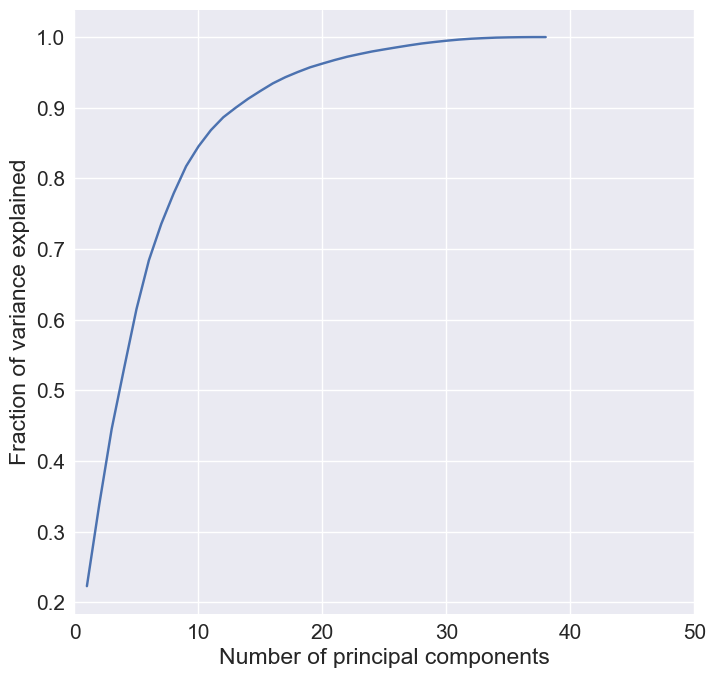

In [22]:
# Do PCA and look at variance explained
fig = plt.figure(figsize=(8,8),dpi=100)

pca = PCA()
pca.fit(df.values)
n_features = df.shape[1]
plt.plot(range(1,n_features+1),pca.explained_variance_ratio_.cumsum())
plt.xlim(0,50);
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of variance explained');

In [23]:
# THe transformed values, ordered from highest to lowest variance dimensions
transformed = pca.transform(df.values)


#model_idx = [idx for idx in enumerate(df.index.values) if type(idx)==str]
'''
#label_model_no_trans_df
model_no_trans_df.index.name = 'Cell_ID'
model_df = model_no_trans_df.copy()
model_df.index.name = 'Cell_ID'
'''
# make experiment dataframe
experiment_idx = [idx for idx in df.index.values if type(idx)==int]
model_no_trans_df = df[~df.index.isin(experiment_idx)]
experiment_idx_labels = [(i,idx) for i,idx in enumerate(df.index.values) if type(idx)==int]

#model_df
#df.labels
model_no_trans_df
experiment_idx_labels = [i[0] for i in experiment_idx_labels]
experiment_idx_labels
model_no_trans_df
model_index_labels = ~df.index.isin(experiment_idx)

model_index_labels


new_models = df.head(7).index.tolist()#  list(range(0,9))#idx for idx in df.index.values if type(idx)==str]
new_model_labels= df.index.isin(new_models)
#len(new_models)
nm = df.head(7)
nm

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
313861539,-0.021434,-0.116652,-0.637298,-0.213688,-0.473929,0.081599,-0.374646,-0.622032,-0.189857,-0.418534,...,-0.040261,-0.352020,-0.420179,1.407775,-0.375810,-0.177697,2.062618,2.916542,2.223978,6.757804
313861677,-0.021910,-0.117481,-0.636489,-0.123535,0.278763,0.082796,-0.375623,-0.620944,-0.088918,-0.466564,...,-0.028545,0.014943,-0.011992,-0.363542,-0.229207,-0.177697,-0.020707,-0.219085,0.084500,-0.185619
313862167,-0.021991,-0.117525,-0.637897,-0.195338,-0.359551,0.082641,-0.374847,-0.622364,-0.174636,-0.466564,...,0.015380,-0.082166,-0.035429,0.280574,-0.234866,-0.177697,-0.061145,-0.219085,-0.009470,-0.185619
313862167,3.509830,4.993646,1.131318,-0.200923,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.333626,...,-0.041917,-0.419130,-0.067079,1.609061,-0.336318,-0.177697,-0.262943,-0.219085,-0.265897,-0.185619
314822529,-0.021983,-0.117481,-0.636943,-0.152256,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.097074,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619
318553131,-0.021977,-0.117343,-0.637730,-0.201721,-0.510090,0.082864,-0.378369,-0.622197,-0.181045,-0.379940,...,0.056529,-0.336840,-0.008005,2.696006,-0.337225,-0.177697,-0.277787,-0.219085,-0.291955,-0.185619
318733871,-0.021983,-0.117481,-0.636921,-0.141087,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.100178,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619


# The Dimensionality reduction assists human visual system classification

It is possible for the human visual system to see three clusters of cell data points.

Let's show that we can classify in this low dimensional space (by just using two features). We will slowly build up to classification via first applying Kmeans, to visualize cluster centres.
And then move on to using a random forest approach to actually visualizing decision boundaries.

In [24]:

isomap = Isomap(n_components=2)
isomap.fit(df.values)
iso = isomap.embedding_.T

# In the slide below:
You can see a plot of the high dimensional Druckman feature space projected into a low dimensional space using rotation matrices found via 
a regular PCA algorithm (not T distributed stochastic neighbourhood embedding). 

PCA uses rotated covariance matrices to project original data into the directions where variance in the data is maximum. One disadvantage of this approach is that two of the highest weighted eigenvalues yield synthetic dimensions, synthetic dimensions that are hard to relate back to a just a few of the original Druckman dimensions. 

In this way PCA and TSNE are useful data exploration tools, by the may not always lead to a complete understanding of the data.

In order to circumvent this problem we will use the variance-explained feature of "Random Forest" classification algorithm. Random Forest variance explained, will probably hint at which dimensions comprize the greatest eigenvalues/weights of the PCA algorithm.

<Figure size 432x288 with 0 Axes>

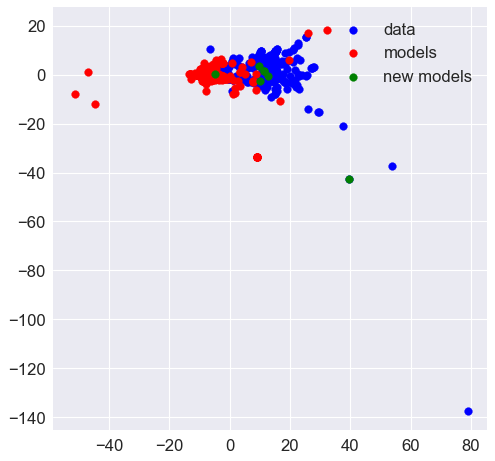

In [25]:
# Do an isomap embedding in 2 dimensions

# Plot that isomap embedding. Each is a model (or a cell, for data)
#plt.scatter(iso);
plt.clf()
fig = plt.figure(figsize=(7,7),dpi=80)
ax = plt.subplot(111)

plt.scatter(iso[0,experiment_idx_labels],iso[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')
plt.scatter(iso[0,model_index_labels],iso[1,model_index_labels],c='red',cmap='rainbow',label='models')
plt.scatter(iso[0,new_model_labels],iso[1,new_model_labels],c='green',cmap='rainbow',label='new models')
legend = ax.legend()#handles, labels, loc="upper right", title="Sizes")
# I don't love the isomap fit

In [26]:

from sklearn.cluster import KMeans
est = KMeans(n_clusters=2)
est.fit(iso.T)
y_kmeans = est.predict(iso.T)
centers = est.cluster_centers_


Another plot but with Kmeans cluster centers included.
Showing the cluster centres is a first step towards showing that machine classification on the dimension reduced version of the Druckman data feature space.

In the plot below the two large yellow dots are the cluster centres for ***(left models),*** ***(right data)***. The Euclidian distnace from each data point from a cluster centre is directly proportional too which category the data point is from (ie model or data, ie red/blue). This visualization would assist us to understand using KMeans nearist neighbours classification algorithm to classify the data.


IN a Random Forest Classification Analysis performed much further below we  examine the dimension that contributes the most to cluster seperation by looking at variance explained. This gives us an educated guess about dimensions that contribute the most weight to the axis of the PCA projection spaces plotted above.

It is likely that the axis in the PCA plot below, are strongly aligned with "Input Resistance" in models and data, as well as "AP2RateOfChangePeakToTroughTest". This second dimension means considering multi-spiking waveforms observed in models and data, at the second Action Potential/Spike, how rapid is the decay from peak to trough of the second AP wave.

<Figure size 432x288 with 0 Axes>

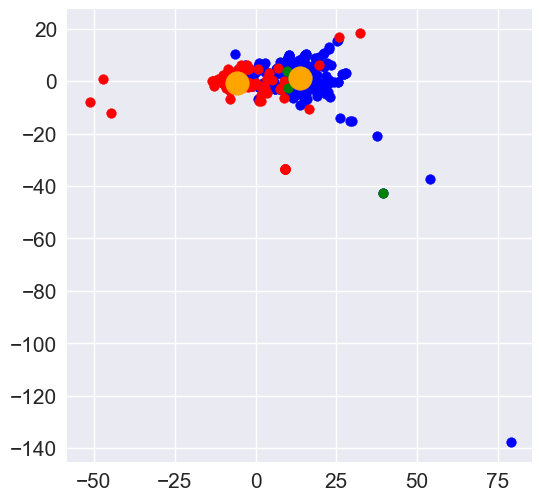

In [27]:

plt.clf()
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.subplot(111)
plt.scatter(iso[0,experiment_idx_labels],iso[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')
plt.scatter(iso[0,model_index_labels],iso[1,model_index_labels],c='red',cmap='rainbow',label='models')
plt.scatter(iso[0,new_model_labels],iso[1,new_model_labels],c='green',cmap='rainbow',label='new models')
plt.scatter(centers[0][0],centers[0][1], s=290, c='orange',edgecolors='orange')
plt.scatter(centers[1][0],centers[1][1], s=290, c='orange',edgecolors='orange')


<Figure size 432x288 with 0 Axes>

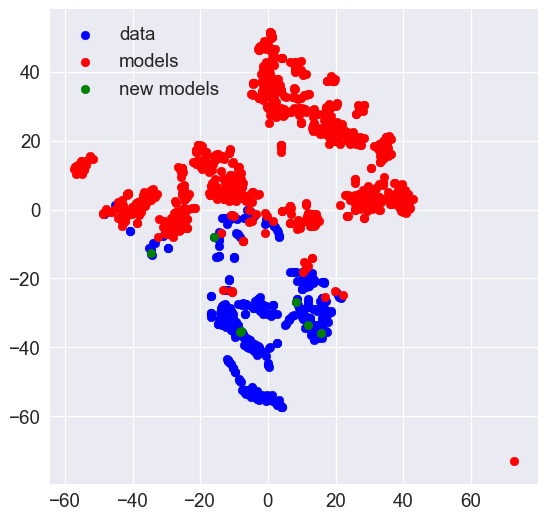

In [28]:
# Do a TSNE embedding in two dimensions
tsne = TSNE(n_components=2, perplexity=30)
tsne.fit(df.values)
x = tsne.embedding_.T
#np.shape(x)
#print(experiment_idx)
# Plot that TSNE embedding. Each is a model (or a cell, for data)
plt.clf()
fig = plt.figure(figsize=(7,7),dpi=90)
ax = plt.subplot(111)
plt.scatter(x[0,experiment_idx_labels],x[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')
plt.scatter(x[0,model_index_labels],x[1,model_index_labels],c='red',cmap='rainbow',label='models')
plt.scatter(x[0,new_model_labels],x[1,new_model_labels],c='green',cmap='rainbow',label='new models')

legend = ax.legend()#handles, labels, loc="upper right", title="Sizes")


### t-SNE 
The TSNE plot does a better job of spatially sperating experimental data from theoretical models in dimension reduced Druckman feature space.




In [29]:
new_model_labels

array([ True,  True,  True, ..., False, False, False])

*Finally we  examine the dimension that contributes the most to cluster seperation by looking at variance explained. This gives us an educated guess about dimensions that contribute the most weight to the axis of the PCA projection spaces plotted above.


In [30]:

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

df_models = df[~df.index.isin(experiment_idx)]
df_data = df[df.index.isin(experiment_idx)]
# Assume they have the same columns

df_combined = pd.concat((df_data, df_models))

groundtruth = np.array(df.index.isin(experiment_idx))
rfc = RandomForestClassifier()
X = df_combined.values
rfc.fit(X, groundtruth)

importances = pd.Series(index = df_combined.columns, data=rfc.feature_importances_)
groundtruth[-9:-1]

print(importances.sort_values(ascending=False)[0:9])


AP2AHPDepthTest                    0.193432
AP2AmplitudeTest                   0.128692
AP2RateOfChangePeakToTroughTest    0.116405
AP1AmplitudeTest                   0.083563
SpikeRateStrongStimTest            0.062671
Burst1ISIMeanTest                  0.057639
AP2WidthHalfHeightTest             0.053819
AP1DelayMeanTest                   0.050389
AP1AHPDepthTest                    0.046658
dtype: float64


In [31]:
#df_combined.columns['ground_truth'] 
models = pd.DataFrame(groundtruth,columns = ['models'])
#a = pandas.DataFrame(df.sum(), columns = ['whatever_name_you_want'])

experiments = copy.copy(models)
experiments = pd.DataFrame(~experiments['models'])#,columns = ['experiments']) #= ~experiments['models']
experiments = experiments.rename(columns={"models":"experiments"})

models

,models
0,True
1,True
2,True
3,True
4,True
...,...
1408,False
1409,False
1410,False
1411,False


In [32]:
experiments

,experiments
0,False
1,False
2,False
3,False
4,False
...,...
1408,True
1409,True
1410,True
1411,True


In [33]:
#df_combined.concat

df_combined_labeled = pd.concat([df_combined, experiments,models])#, axis=1, sort=False)
df_combined_labeled['experiments']
df_combined_labeled['models']

313861539      NaN
313861677      NaN
313862167      NaN
313862167      NaN
314822529      NaN
             ...  
1408         False
1409         False
1410         False
1411         False
1412         False
Name: models, Length: 4239, dtype: object

As I wrote above Random Forest Variance explained, tells us the dimensions of the Druckman feature space that most strongly assist in classifying models versus data. When we identify features that seperate models and data using Variance Explained, we are then able to iteratively variables that contribute more heavily to data variance. We can remove variables that explain most variance, until machine classification can no longer tell models and data apart, leaving us with a small list of tests which models need to perform better on, these tests correspond to measurable electrical properties of cells that need to be better aligned with data.

Two such measurable electrical properties are Druckman features with high variance explained are re: "Input Resistance" in models and data, as well as "AP2RateOfChangePeakToTroughTest". This second dimension called AP2RateOfChangePeakToTroughTest means: when considering multi-spiking waveforms observed, at the second Action Potential/Spike, how rapid is the average decay from peak to trough of the second AP wave. Since Action Potential wave attack and decay shapes are non-linear, the instantaneous gradient from the peak of the wave is not informative, and it is more useful to measure the time interval needed needed for a decay from a spike, to a state of hyperpolarization, corresponding to a neurons "refractory-period".

Already, we are have arrived at useful information, pertaining to the point of the exercise, as we now have a small list of electrical tests, that we want optimized models to perform better on, such that models and data will be more aligned with each other.

As neural modelers with a great interest in mimicing a diverse range of experimental data using models. The least convincing aspects of our models as mimics of data, are these top ten features. In other words the least convincing aspects of our models are: AP2RateOfChangePeakToTroughTest, Input Resistance values (a scalar), and the amplitude of the first and second spike.





# Prediction Results When I Use Random Forests on all 48 Druckman dimensions
* remember that our ground truth labels are booleans that are defined like this:
groundtruth = np.array(df_combined.index.isin(experiment_idx))
Which is labeled as "True" for this data point is an experiment, and "False" for this data point is a model.
Machine classification can successfuly discrimate that our optimized cells are models and not data (this is bad news for us).

In this context in order to bolster out optimized models, a high ***false-negative*** rate is desirable. Unfortunately for us, that is not what we see. The Random Forest Classifier (RFC) correctly identies that all 11 of the new optimized cells are not derived from experiments (they are models). That is bad news for us.


In [34]:
df_combined = df_combined.fillna(0).applymap(f)

test_frame = test_frame.fillna(0).applymap(f)

rfc = RandomForestClassifier()
X = df_combined.values
rfc.fit(X, groundtruth)
predictions = rfc.predict(test_frame.values)
print(len(test_frame.values))
print(predictions)


11
[False False False False False False False False False False False]


In [35]:
rfc = RandomForestClassifier()
fig = plt.figure(figsize=(9,9),dpi=110)

X = x.T

rfc.fit(x.T, groundtruth)
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = rfc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


<Figure size 990x990 with 0 Axes>

In [36]:
tsne.fit(test_frame)
xt = tsne.embedding_.T
predictions = rfc.predict(xt.T)
print(predictions)

[False False  True  True False False False False False False False]


Now we have fitted a RFC using only two articial dimensions eminating from PCA rotation vectors that provide us with 2D projection space.
# Interpretation, what does this list of Booleans mean?
Unfortunately for the author (whose aim is to bolster the validity of the new optimized models).

When we feed in the new optimized models as "validation data", in this context, the RFC is still okay at classifying our new models correctly as models, and not data. However, the RFC performance is significanlty worse, as the optimized cells have tricked the RFC ***4*** times.

Also since the output of the TSNE-PCA varies with each run, as it is seeded with a psuedo random numnber generator, the projection space that the RFC acts on is different each time. Meaning that the ***FPR*** and the ***TPR*** rates vary slightly on each run.


# In the plot below we show the we show the decision boundary as used by our classifier.
The decision boundary llows us to see if the newer optimized models are classified as data or models



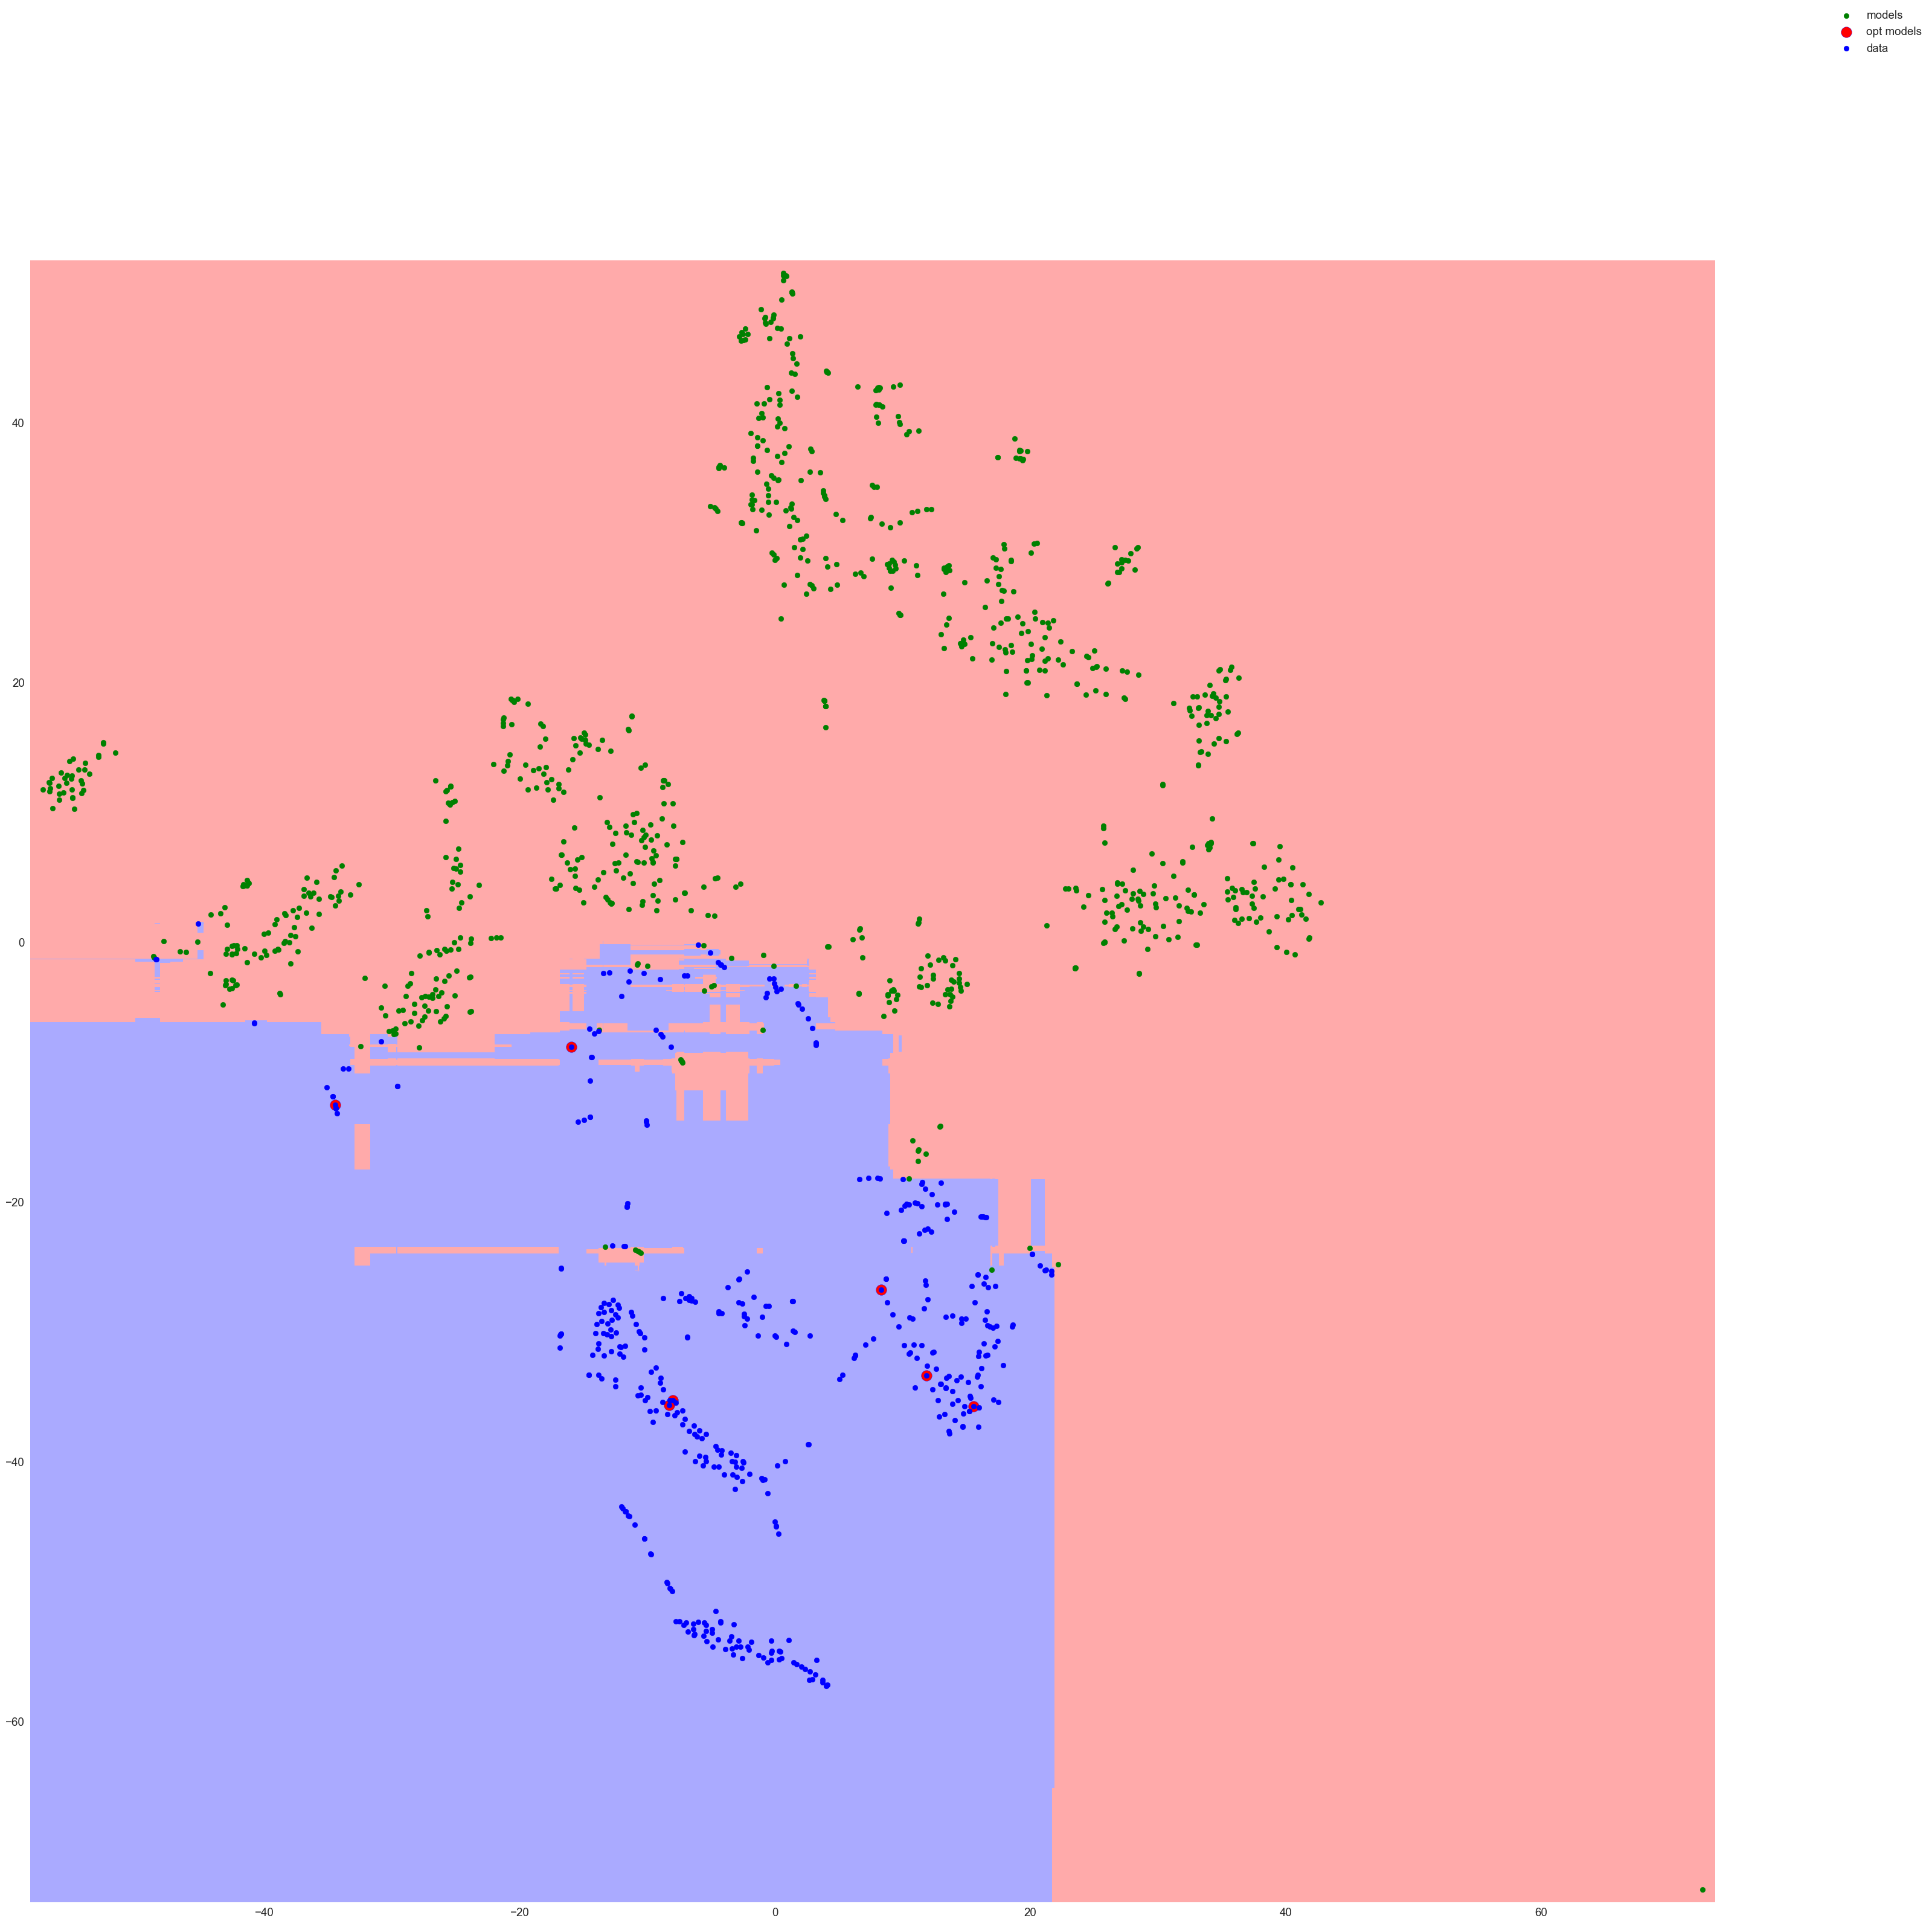

In [37]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
fig = plt.figure(figsize=(40,40),dpi=90)
#ax = plt.subplot(111)

#n_neighbors = 15

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
#plt.scatter(x[0,experiment_idx_labels],x[1,experiment_idx_labels],c='g',cmap='rainbow',label='data')
plt.scatter(x[0,model_index_labels],x[1,model_index_labels],c='g',cmap='rainbow',label='models')

plt.scatter(x[0,new_model_labels],x[1,new_model_labels], s=200, c='red',edgecolors='blue',label='opt models')
plt.scatter(x[0,experiment_idx_labels],x[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.legend()
legend = fig.legend()
plt.show()



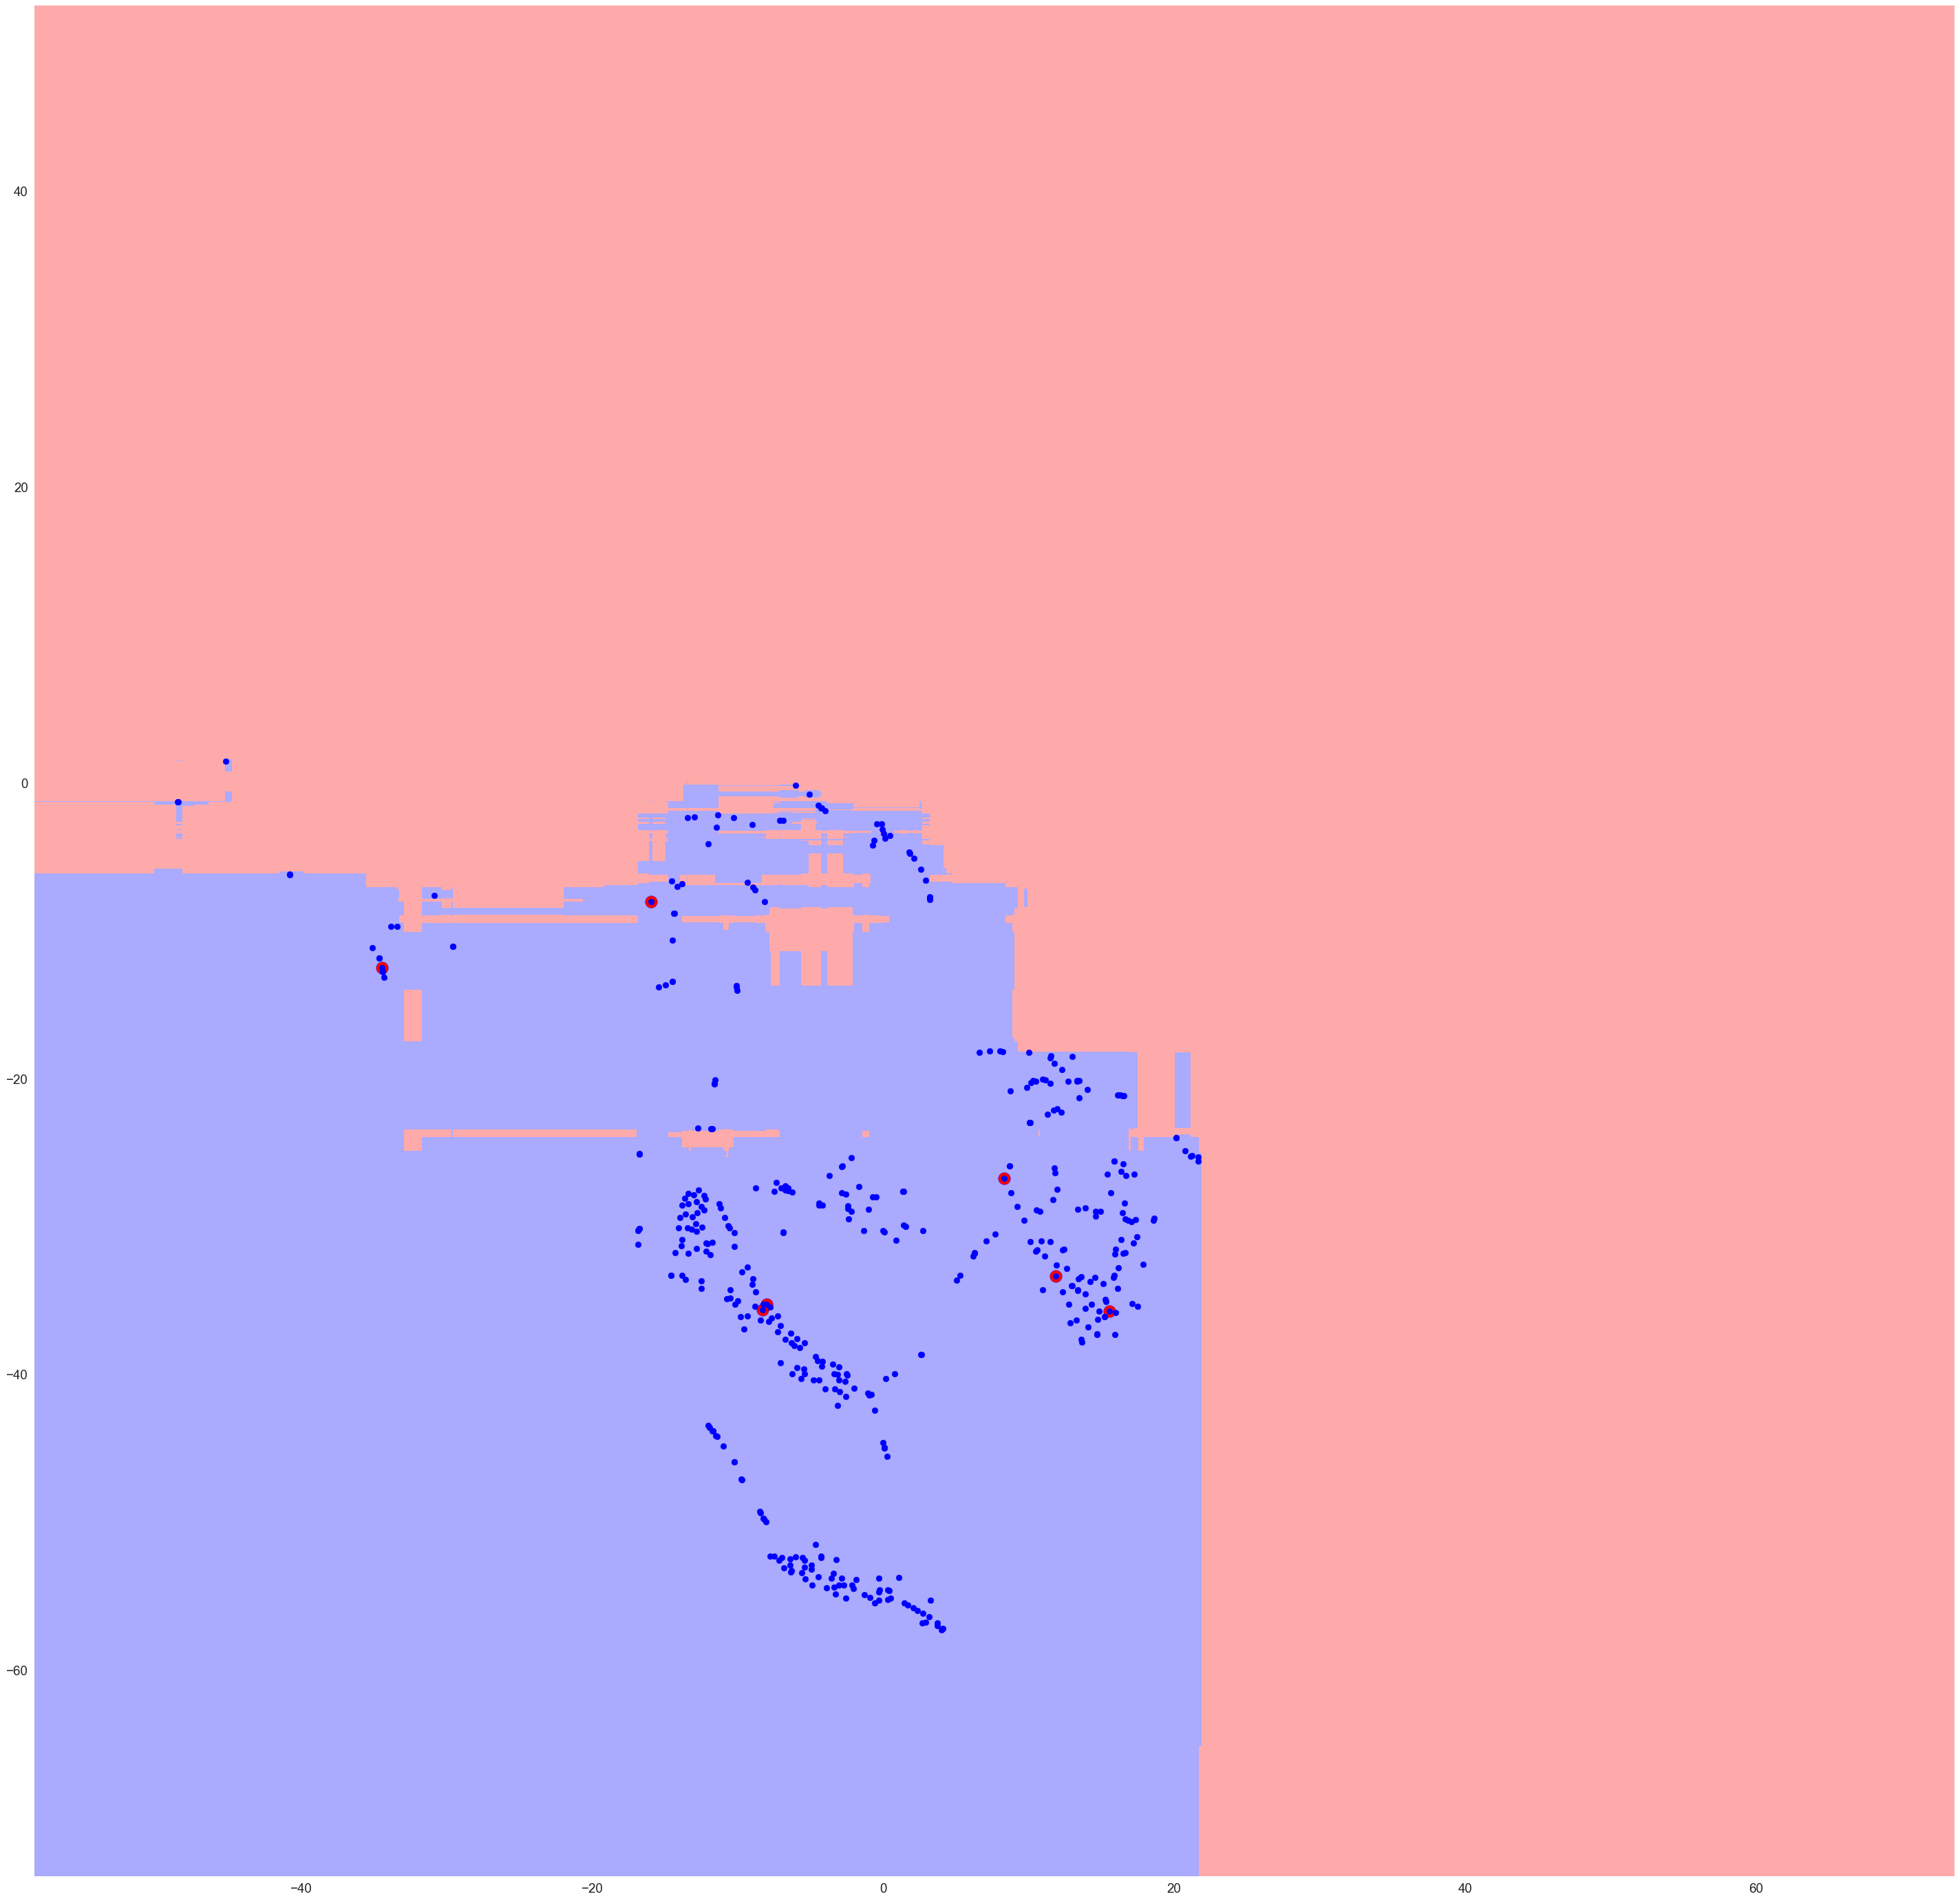

In [38]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
fig = plt.figure(figsize=(40,40),dpi=90)

#n_neighbors = 15

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(x[0,new_model_labels],x[1,new_model_labels], s=200, c='red',edgecolors='blue')
plt.scatter(x[0,experiment_idx_labels],x[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()



* Blue means experimental data, red means model, as machine categorized using Sklearns Random Forest classifier.

A general trend is apparent at the macro scale. It seems as if the bottom 2/3rds of the plane belong to data, and the remaining upper 1/3rd of the plane belongs to models, however you can also see on a micro scale there are lots of small pockets, or islands of model decision territory inside, what is more generally regarded as data territory.

Although the large red dots, appear in the correct side of the macro decision boundary, zooming in would reveal that these optimized models are in fact enveloped by model island that is excatly small enough to contain them. Therefore random forest classification, correctly classifies the optimized models as models.

# The above figure allows us
To argue that the newer optimized models are closer to cluster centres and often fall on the experimental data side of the decision boundary.


In [39]:
groundtruth
predictions = rfc.predict(X)
print(np.shape(predictions))


(1413,)


In [40]:
df_combined.tail()

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
NMLCL001542,0.714068,0.264788,1.793203,-0.138694,-0.146911,-0.042206,-0.197962,1.517995,-0.113752,1.136408,...,-0.033633,0.036056,2.411172,2.394077,-0.440229,-0.177697,-0.391307,-0.219085,-0.311599,-0.185619
NMLCL001594,0.318570,0.336069,2.124820,-0.116355,-0.107606,-0.068550,1.212822,2.067853,-0.089719,0.033454,...,0.128710,-0.275532,-0.060104,3.138835,-0.468977,-0.177697,-0.390273,-0.219085,-0.305626,-0.185619
NMLCL001650,-0.020508,-0.118786,1.013376,0.979844,-0.508518,-29.442343,2.057899,1.090665,1.004598,-0.464848,...,58.193975,0.571763,-0.066985,-0.061613,-0.012694,-0.177697,0.341416,-0.219085,0.424633,-0.185619
NMLCL001657,-0.018762,-0.112707,1.164465,0.697417,0.790123,0.043336,2.389129,1.246569,0.721005,0.995752,...,17.328016,1.018819,-0.066753,-0.101870,-0.167606,-0.177697,0.252270,-0.219085,0.528867,-0.185619
NMLCL001660,-0.019623,-0.236932,-0.364181,-0.181776,-0.509304,-73.486329,7.477759,-0.339514,-0.163421,1.749637,...,0.022252,0.661266,0.075142,0.220188,-0.200842,-0.177697,-0.020046,-0.219085,0.020703,-0.185619


# Lets switch back to using all 38 features to classify
Only as its easier for me to debug, and I can make progress more quickly.
Using cross validation below you can see that this approach is generalizable.

In [41]:
#new_models = df.head(7).index.tolist()

#predictions = rfc.predict(df.head(7).values)

#df_combined.columns
from sklearn import metrics

In [42]:
#!pip install --update sklearn
len(groundtruth)
groundtruth
df_combined.head()

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
313861539,-0.021434,-0.116652,-0.637298,-0.213688,-0.473929,0.081599,-0.374646,-0.622032,-0.189857,-0.418534,...,-0.040261,-0.352020,-0.420179,1.407775,-0.375810,-0.177697,2.062618,2.916542,2.223978,6.757804
313861677,-0.021910,-0.117481,-0.636489,-0.123535,0.278763,0.082796,-0.375623,-0.620944,-0.088918,-0.466564,...,-0.028545,0.014943,-0.011992,-0.363542,-0.229207,-0.177697,-0.020707,-0.219085,0.084500,-0.185619
313862167,-0.021991,-0.117525,-0.637897,-0.195338,-0.359551,0.082641,-0.374847,-0.622364,-0.174636,-0.466564,...,0.015380,-0.082166,-0.035429,0.280574,-0.234866,-0.177697,-0.061145,-0.219085,-0.009470,-0.185619
313862167,3.509830,4.993646,1.131318,-0.200923,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.333626,...,-0.041917,-0.419130,-0.067079,1.609061,-0.336318,-0.177697,-0.262943,-0.219085,-0.265897,-0.185619
314822529,-0.021983,-0.117481,-0.636943,-0.152256,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.097074,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619


In [43]:
from sklearn.model_selection import train_test_split
for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(df_combined.values, groundtruth, test_size=0.5, random_state=42)    

rfc = RandomForestClassifier()
#X = df_combined.values
'''
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
for i,j in enumerate(predictions):
    if j!=y_test[i]:
        print(j,y_test[i],i)
'''   
#print(y_test[291],'these are the data/models that resist classification')
#print(y_test[340],'these are the data/models that resist classification')

False True 287


# All 7 seven new models are classified as False

Ie it is false that they are percieved as models, its true that they are percieved as data.

In [44]:
len(X_train)
new_models
gt = [False for i in range(0,len(nm))] 
from sklearn import svm
nm

gt

[False, False, False, False, False, False, False]

In [45]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
sc = clf.score(nm, gt)
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(clf,nm, gt, cv=5)
#scores
sc

from sklearn.metrics import roc_auc_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
roc_auc_score(y_true, y_scores)


0.75

In [46]:
score = metrics.f1_score(y_test, predictions)


In [47]:
score

0.9978401727861772

# In the python code below...
We are not interested so much in the main research question, of "are the new optimized cells, better mimics of data".
We are more interested in a secondary question: "Was our comparison of models and data fair?, and Did we use do our best to utilize the full potential of machine classification, in sensing the differences between models and data.

To answer that question we assess the accuracy of RandomForest Classifier as applied to the high dimensional Druckman space.


In [48]:
def incomplete():
    import numpy as np, pylab as pl
    # get overall accuracy and F1 score to print at top of plot
    pscore = metrics.accuracy_score(y_test, predictions)
    pred=predictions
    # get size of the full label set
    dur = 2#len(categories)
    print("Building testing confusion matrix...")
    # initialize score matrices
    trueScores = np.zeros(shape=(dur,dur))
    predScores = np.zeros(shape=(dur,dur))
    # populate totals
    categories = ["models","data"]
    for i in range(len(y_test)-1):
      trueIdx = y_test[i]
      predIdx = pred[i]
      trueScores[trueIdx,trueIdx] += 1
      predScores[trueIdx,predIdx] += 1
    # create %-based results
    trueSums = np.sum(trueScores,axis=0)
    conf = np.zeros(shape=predScores.shape)
    for i in range(len(predScores)):
      for j in range(dur):
        conf[i,j] = predScores[i,j] / trueSums[i]
    # plot the confusion matrix
    hq = pl.figure(figsize=(15,15));
    aq = hq.add_subplot(1,1,1)
    aq.set_aspect(1)
    res = aq.imshow(conf,cmap=pl.get_cmap('Greens'),interpolation='nearest',vmin=-0.05,vmax=1.)
    width = len(conf)
    height = len(conf[0])
    done = []
    # label each grid cell with the misclassification rates
    for w in range(width):
      for h in range(height):
          pval = conf[w][h]
          c = 'k'
          rais = w
          if pval > 0.5: c = 'w'
          if pval > 0.001:
            if w == h:
              aq.annotate("{0:1.1f}%\n{1:1.0f}/{2:1.0f}".format(pval*100.,predScores[w][h],trueSums[w]), xy=(h, w), 
                      horizontalalignment='center',
                      verticalalignment='center',color=c,size=10)
            else:
              aq.annotate("{0:1.1f}%\n{1:1.0f}".format(pval*100.,predScores[w][h]), xy=(h, w), 
                      horizontalalignment='center',
                      verticalalignment='center',color=c,size=10)
    # label the axes
    pl.xticks(range(width), categories[:width],rotation=90,size=10)
    pl.yticks(range(height), categories[:height],size=10)
    # add a title with the F1 score and accuracy
    aq.set_title( " Prediction, Test Set (f1: "+"{0:1.3f}".format(score)+', accuracy: '+'{0:2.1f}%'.format(100*pscore)+", " + str(len(y_test)) + " items)",fontname='Arial',size=10,color='k')
    aq.set_ylabel("Actual",fontname='Arial',size=10,color='k')
    aq.set_xlabel("Predicted",fontname='Arial',size=10,color='k')
    pl.grid(b=True,axis='both')

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC


import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

def plot_roc_curve(X_train, y_train,X_test):
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    #y_score = rfc.fit(X_test, y_train)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    #roc_auc = dict()
    #for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()    
        
        #roc_auc[i] = auc(fpr[i], tpr[i])
def incomplete_2():
        
    X = df_combined.values
    y = groundtruth
    n_samples, n_features = X.shape

    # Add noisy features
    random_state = np.random.RandomState(0)
    X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

    # #############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=6)
    classifier = svm.SVC(kernel='linear', probability=True,
                         random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        rfc = RandomForestClassifier()
        rfc.fit(X[train], y[train])
        score = rfc.predict(X[train])
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        fpr[i], tpr[i], _ = roc_auc_score(y_test[:, i], y_score[:, i])
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()

# This will enable us to use a cross-validation Approach.
Cross-validation will help us to check the generalizability of our model, by better navigating the bias-variance tradeoff.

# Report on misclassification.
Even though RFC can be over-fit by using all the data over 148 features a False negative is still sometimes reported.
Experimental data point with identifier: "482764620" is sometimes falsely classified as a model, but we know from ground truth that it is an experiment.

The outputs of thistest are a bit different each time.

In [50]:
print('448-458 are models that we are happy were misclassified as data')    
here = np.array(df_combined.values)
predictions = rfc.predict(here)
ground_truth = groundtruth
#for i,pred in enumerate(predictions):
for j,(i, row) in enumerate(df_combined.iterrows()):

    if groundtruth[j]!=predictions[j]:
        print(i,j)
    
df_combined.iloc[155]


448-458 are models that we are happy were misclassified as data
482764620 155


AP12AmplitudeDropTest                           -0.021983
AP1SSAmplitudeChangeTest                        -0.117481
AP1AmplitudeTest                                -0.638438
AP1WidthHalfHeightTest                          -0.232836
AP1WidthPeakToTroughTest                        -0.510090
AP1RateOfChangePeakToTroughTest                  0.082864
AP1AHPDepthTest                                 -0.378369
AP2AmplitudeTest                                -0.622929
AP2WidthHalfHeightTest                          -0.214692
AP2WidthPeakToTroughTest                        -0.466564
AP2RateOfChangePeakToTroughTest                  0.115096
AP2AHPDepthTest                                 -0.349555
AP12AmplitudeChangePercentTest                  -0.090269
AP12HalfWidthChangePercentTest                  -0.141986
AP12RateOfChangePeakToTroughPercentChangeTest    0.224354
AP12AHPDepthPercentChangeTest                   -0.002431
InputResistanceTest                             -0.305368
AP1DelayMeanTe

CPU times: user 24.2 s, sys: 3.63 s, total: 27.8 s
Wall time: 28 s
CPU times: user 28.5 s, sys: 3.94 s, total: 32.4 s
Wall time: 32.7 s
CPU times: user 28.2 s, sys: 3.66 s, total: 31.9 s
Wall time: 32.1 s
CPU times: user 30.8 s, sys: 3.78 s, total: 34.6 s
Wall time: 34.8 s


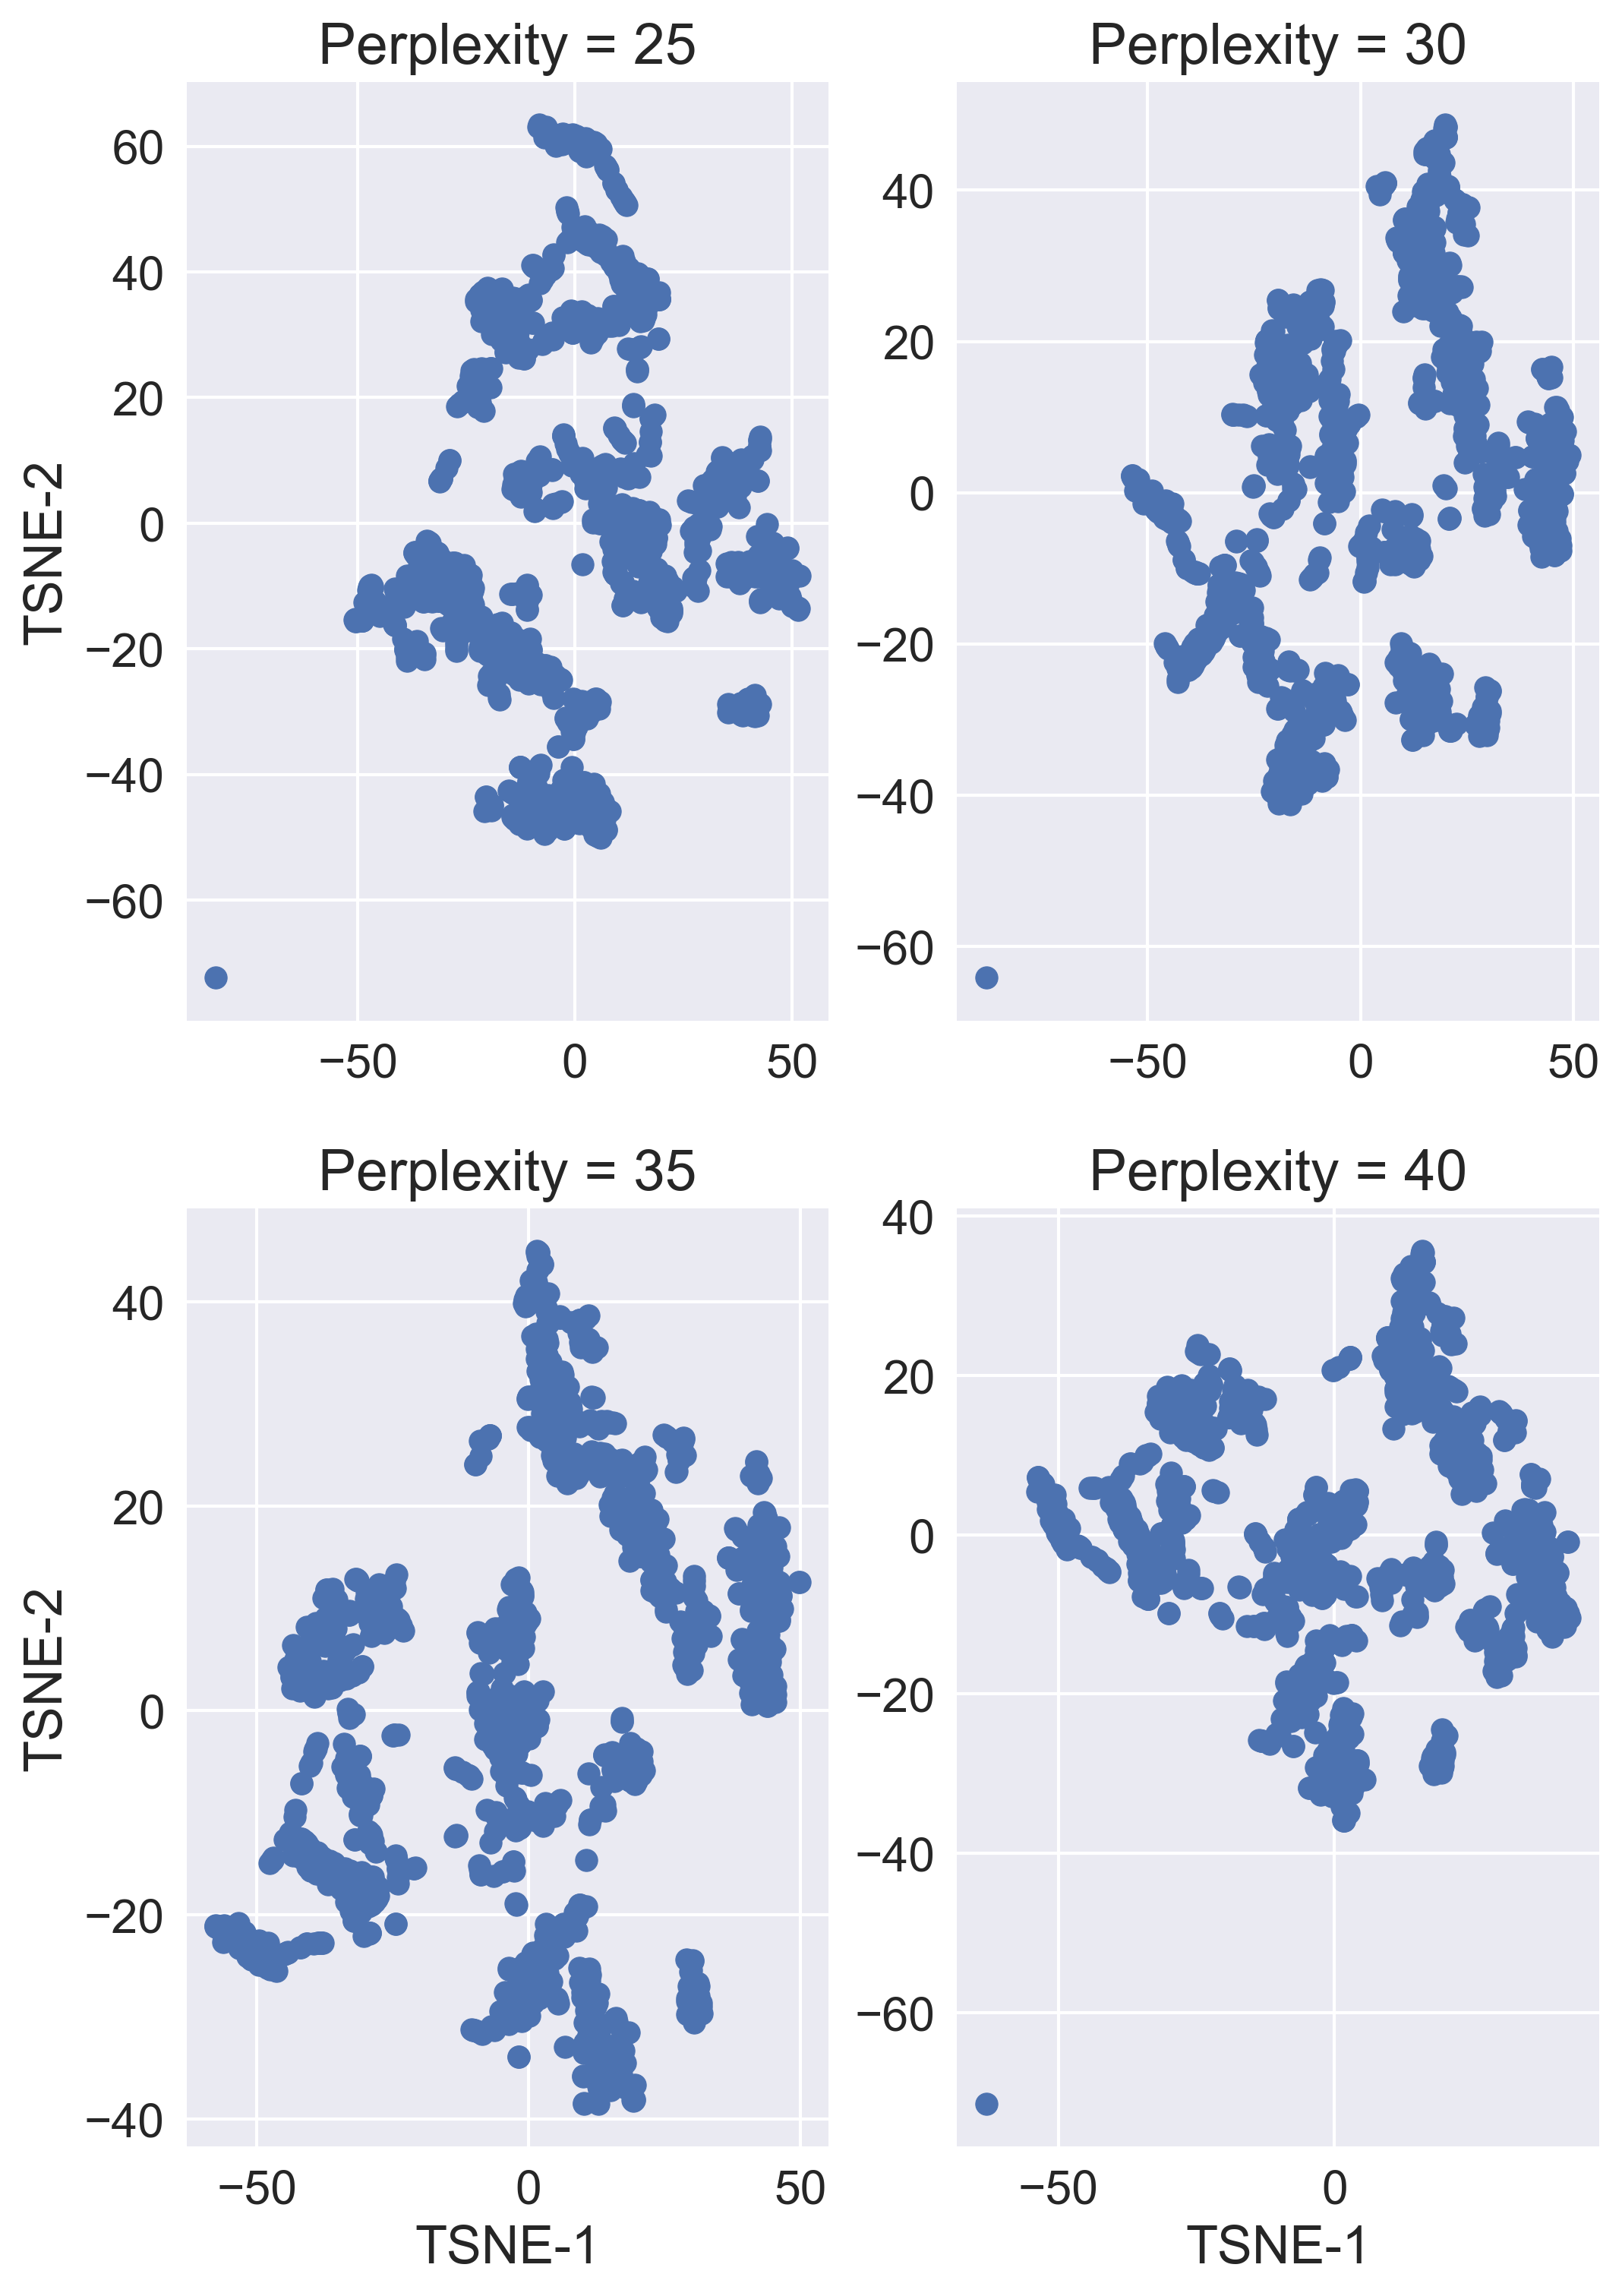

In [51]:
# PLay around with the value of perplexity. Recommended values are between 5 and 50.  
#See if any of the clusters that pop out mean anything (do they match existing cell type clusters?  
# Do they match known firnig patterns?  
# Where does the data fit in when it is also plotted in this space?)

perplexities = [25,30,35,40]

fig, ax = plt.subplots(2,2,figsize=(8,12),dpi=300)
ax = ax.ravel()

for i, perp in enumerate(perplexities):

    # init = 'pca' or 'random'
    tsne = TSNE(n_components=2,
                init='random',      
                random_state=0,
                perplexity=perp,         # default = 30, should be less than the number of samples
                n_iter=1000)             # default = 1000


    %time tsne.fit(df.values) # can't use transpose


    ax[i].scatter(*tsne.embedding_.T);

    if i in [2,3]:
        ax[i].set_xlabel('TSNE-1')

    if i in [0,2]:
        ax[i].set_ylabel('TSNE-2')
    ax[i].set_title('Perplexity = %s' %perp)

### Repeat above with just experimental data

In [52]:
# make model dataframe
model_idx = [idx for idx in df.index.values if type(idx)==str]
model_no_trans_df = df[df.index.isin(model_idx)]
model_no_trans_df.index.name = 'Cell_ID'
model_df = model_no_trans_df.copy()
model_df.index.name = 'Cell_ID'

# make experiment dataframe
experiment_idx = [idx for idx in df.index.values if type(idx)==int]
experiment_no_trans_df = df[df.index.isin(experiment_idx)]
experiment_df = experiment_no_trans_df.copy()
experiment_df

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
313861539,-0.021434,-0.116652,-0.637298,-0.213688,-0.473929,0.081599,-0.374646,-0.622032,-0.189857,-0.418534,...,-0.040261,-0.352020,-0.420179,1.407775,-0.375810,-0.177697,2.062618,2.916542,2.223978,6.757804
313861677,-0.021910,-0.117481,-0.636489,-0.123535,0.278763,0.082796,-0.375623,-0.620944,-0.088918,-0.466564,...,-0.028545,0.014943,-0.011992,-0.363542,-0.229207,-0.177697,-0.020707,-0.219085,0.084500,-0.185619
313862167,-0.021991,-0.117525,-0.637897,-0.195338,-0.359551,0.082641,-0.374847,-0.622364,-0.174636,-0.466564,...,0.015380,-0.082166,-0.035429,0.280574,-0.234866,-0.177697,-0.061145,-0.219085,-0.009470,-0.185619
313862167,3.509830,4.993646,1.131318,-0.200923,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.333626,...,-0.041917,-0.419130,-0.067079,1.609061,-0.336318,-0.177697,-0.262943,-0.219085,-0.265897,-0.185619
314822529,-0.021983,-0.117481,-0.636943,-0.152256,-0.510090,0.082864,-0.378369,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.097074,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593618144,-0.021983,-0.117481,-0.637439,-0.188158,-0.407897,0.082439,-0.374608,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.325048,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619
596609577,-0.021983,-0.117481,-0.637375,-0.204114,-0.440913,0.082241,-0.374834,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.323520,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619
609435731,-0.021983,-0.117481,-0.637266,-0.197732,-0.440913,0.082309,-0.375826,-0.622929,-0.214692,-0.466564,...,-0.041917,-0.419130,-0.067079,-0.464185,-0.265739,-0.177697,-0.448863,-0.219085,-0.393358,-0.185619
609775336,-0.021826,-0.117078,-0.637665,-0.210497,-0.440913,0.082407,-0.375758,-0.622208,-0.192261,-0.397951,...,-0.036096,0.058481,0.195409,-0.182384,0.414173,-0.177697,0.467402,-0.219085,0.011457,-0.185619


In [53]:
model_df[:] = ss.fit_transform(model_no_trans_df.values);

In [54]:
model_no_trans_df.head()

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
Cell_ID,,,,,,,,,,,,,,,,,,,,,
NMLCL000073,-0.044672,0.606438,1.525351,-0.151459,-0.275046,-0.115861,0.717227,1.634594,-0.132979,-0.210980,...,-0.025218,0.352267,0.099315,0.179931,-0.450162,-0.177697,-0.391927,-0.219085,-0.328764,-0.185619
NMLCL000087,0.182327,0.387108,1.893904,-0.162628,-0.231024,-0.132201,1.699496,1.899049,-0.144194,-0.154374,...,-0.024480,1.293196,1.623745,-0.142127,-0.461097,-0.177697,-0.329575,-0.219085,-0.156840,-0.185619
NMLCL000089,0.170725,0.376769,1.880369,-0.164224,-0.226307,-0.128585,1.734304,1.891035,-0.144194,-0.151801,...,-0.024482,1.296016,1.619024,-0.142127,-0.460763,-0.177697,-0.329079,-0.219085,-0.156265,-0.185619
NMLCL000090,0.204680,0.433623,1.901079,-0.161032,-0.244388,-0.144157,1.725102,1.894871,-0.144194,-0.169812,...,-0.024512,1.307654,1.685069,-0.142127,-0.461623,-0.177697,-0.330526,-0.219085,-0.156265,-0.185619
NMLCL000091,0.163579,0.400917,1.897350,-0.164224,-0.227879,-0.130036,1.699879,1.912376,-0.144194,-0.150944,...,-0.024480,1.296606,1.618543,-0.142127,-0.460763,-0.177697,-0.328996,-0.219085,-0.155911,-0.185619


In [55]:
model_df.head()

,AP12AmplitudeDropTest,AP1SSAmplitudeChangeTest,AP1AmplitudeTest,AP1WidthHalfHeightTest,AP1WidthPeakToTroughTest,AP1RateOfChangePeakToTroughTest,AP1AHPDepthTest,AP2AmplitudeTest,AP2WidthHalfHeightTest,AP2WidthPeakToTroughTest,...,ISICVTest,ISIMedianTest,ISIBurstMeanChangeTest,SpikeRateStrongStimTest,AP1DelayMeanStrongStimTest,AP1DelaySDStrongStimTest,AP2DelayMeanStrongStimTest,AP2DelaySDStrongStimTest,Burst1ISIMeanStrongStimTest,Burst1ISISDStrongStimTest
Cell_ID,,,,,,,,,,,,,,,,,,,,,
NMLCL000073,-0.772055,0.304427,-0.172629,-0.226706,-0.325255,0.038536,-0.504866,0.055726,-0.432144,-0.362886,...,-0.091103,0.053174,0.202657,-0.601486,-0.403974,1.0,-0.272713,-0.053729,-0.541664,-0.072169
NMLCL000087,0.472471,-0.019486,0.899053,-0.326674,-0.242898,0.032113,1.300986,0.754423,-0.647054,-0.273345,...,-0.090734,1.331416,5.628498,-0.849687,-0.608634,1.0,-0.104700,-0.053729,0.085025,-0.072169
NMLCL000089,0.408864,-0.034755,0.859695,-0.340955,-0.234074,0.033535,1.364978,0.733249,-0.647054,-0.269275,...,-0.090735,1.335246,5.611697,-0.849687,-0.602378,1.0,-0.103363,-0.053729,0.087121,-0.072169
NMLCL000090,0.595027,0.049209,0.919917,-0.312393,-0.267899,0.027414,1.348062,0.743383,-0.647054,-0.297765,...,-0.090750,1.351057,5.846769,-0.849687,-0.618465,1.0,-0.107262,-0.053729,0.087121,-0.072169
NMLCL000091,0.369685,0.000907,0.909074,-0.340955,-0.237015,0.032964,1.301690,0.789632,-0.647054,-0.267919,...,-0.090734,1.336048,5.609984,-0.849687,-0.602378,1.0,-0.103140,-0.053729,0.088411,-0.072169


CPU times: user 17.9 s, sys: 2.52 s, total: 20.4 s
Wall time: 20.6 s
CPU times: user 19.5 s, sys: 2.69 s, total: 22.2 s
Wall time: 22.3 s
CPU times: user 19.1 s, sys: 2.36 s, total: 21.5 s
Wall time: 21.5 s
CPU times: user 21 s, sys: 2.43 s, total: 23.5 s
Wall time: 23.5 s


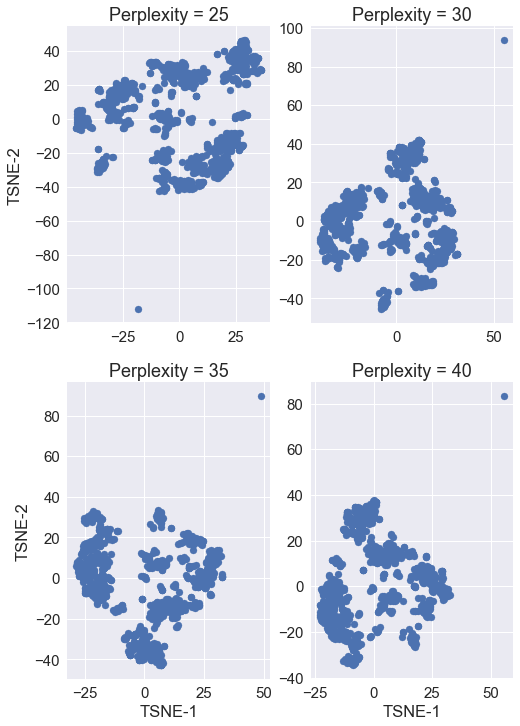

In [56]:
# PLay around with the value of perplexity. Recommended values are between 5 and 50.  
#See if any of the clusters that pop out mean anything (do they match existing cell type clusters?  
# Do they match known firnig patterns?  
# Where does the data fit in when it is also plotted in this space?)

perplexities = [25,30,35,40]

df = model_df.copy()

fig, ax = plt.subplots(2,2,figsize=(8,12))
ax = ax.ravel()

for i, perp in enumerate(perplexities):

    # init = 'pca' or 'random'
    tsne = TSNE(n_components=2,
                init='random',      
                random_state=0,
                perplexity=perp,         # default = 30, should be less than the number of samples
                n_iter=1000)             # default = 1000


    %time tsne.fit(df.values) # can't use transpose


    ax[i].scatter(*tsne.embedding_.T);

    if i in [2,3]:
        ax[i].set_xlabel('TSNE-1')

    if i in [0,2]:
        ax[i].set_ylabel('TSNE-2')
    ax[i].set_title('Perplexity = %s' %perp)

In [57]:
try:
    os.mkdir('data')
except:
    pass
filename = os.path.join(path2data,'new_cortical_ephys.csv')

model_df.to_csv(filename)

filename = os.path.join(path2data,'new_cortical_ephys_no_trans.csv')
model_no_trans_df.to_csv(filename)

filename = os.path.join(path2data,'experiment_ephys_no_trans.csv')
experiment_no_trans_df.to_csv(filename)